In [1]:
import matplotlib.pyplot as plt
from mxnet import nd, autograd, init, context, gluon
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
import numpy as np
from IPython import display

In [2]:
class Animator(object):
    def __init__(self, xlabel=None, ylabel=None, legend=[], xlim=None,
                 ylim=None, xscale='linear', yscale='linear', fmts=None,
                 nrows=1, ncols=1, figsize=(3.5, 2.5)):
        """Incrementally plot multiple lines."""
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1: self.axes = [self.axes,]
        # use a lambda to capture arguments
        self.config_axes = lambda : Animator.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
    
    @staticmethod
    def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
      """A utility function to set matplotlib axes"""
      axes.set_xlabel(xlabel)
      axes.set_ylabel(ylabel)
      axes.set_xscale(xscale)
      axes.set_yscale(yscale)
      axes.set_xlim(xlim)
      axes.set_ylim(ylim)
      if legend: axes.legend(legend)
      axes.grid()
    
    def add(self, x, y):
        """Add multiple data points into the figure."""
        if not hasattr(y, "__len__"): y = [y]
        n = len(y)
        if not hasattr(x, "__len__"): x = [x] * n
        if not self.X: self.X = [[] for _ in range(n)]
        if not self.Y: self.Y = [[] for _ in range(n)]
        if not self.fmts: self.fmts = ['-'] * n
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [3]:
def show_images(X, nrows, ncols):
    _, axes = plt.subplots(nrows, ncols)
    axes = axes.flatten()
    for img, ax in zip(X, axes):
        ax.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    return axes

In [4]:
def get_dataloader(batch_size, resize=None, shuffle=True):
    transform_list = []
    if resize is not None:
        transform_list.append(transforms.Resize(resize))
    transform_list.append(transforms.ToTensor())
    transformer = transforms.Compose(transform_list)
    
    train = gluon.data.vision.datasets.FashionMNIST(train=True)
    train = train.transform_first(transformer)
    train_iter = gluon.data.DataLoader(train, batch_size, shuffle, num_workers=4)
    
    test = gluon.data.vision.datasets.FashionMNIST(train=False)
    test = test.transform_first(transformer)
    test_iter = gluon.data.DataLoader(test, batch_size, shuffle=False, num_workers=4)
    
    return train_iter, test_iter, train, test

In [5]:
class Residual(nn.Block):
    def __init__(self, num_channels, use_1x1=False, strides=1, **kwargs):
        super(Residual, self).__init__(**kwargs)
        self.conv1 = nn.Conv2D(num_channels, kernel_size=3, strides=strides, padding=1)
        self.conv2 = nn.Conv2D(num_channels, kernel_size=3, padding=1)
        if use_1x1:
            self.conv3 = nn.Conv2D(num_channels, kernel_size=1, strides=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm()
        self.bn2 = nn.BatchNorm()
        
    def forward(self, X):
        Y = nd.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return nd.relu(X + Y)

In [6]:
class ResNet(nn.Block):
    def __init__(self, num_classes, **kwargs):
        super(ResNet, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.network = self.get_network()
    
    def residual_block(self, num_channels, num_residuals, first_block=False):
        resblk = nn.Sequential()
        for i in range(num_residuals):
            if i==0 and not first_block:
                resblk.add(Residual(num_channels, use_1x1=True, strides=2))
            else:
                resblk.add(Residual(num_channels))
        return resblk
    
    def get_network(self):
        blk = nn.Sequential()
        blk.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3))
        blk.add(nn.BatchNorm())
        blk.add(nn.Activation('relu'))
        blk.add(nn.MaxPool2D(pool_size=3, strides=2, padding=1))
        blk.add(self.residual_block(64, 2, first_block=True))
        blk.add(self.residual_block(128, 2))
        blk.add(self.residual_block(256, 2))
        blk.add(self.residual_block(512, 2))
        blk.add(nn.GlobalAvgPool2D())
        blk.add(nn.Dense(self.num_classes))
        return blk
    def __getitem__(self, key):
        return self.network[key]
    def __len__(self):
        return len(self.network)
    def forward(self, X):
        Y = self.network(X)
        return Y

In [7]:
batch_size = 4
train_iter, test_iter, train, test = get_dataloader(batch_size, resize=112, shuffle=True)

(4, 1, 112, 112)
(4,)


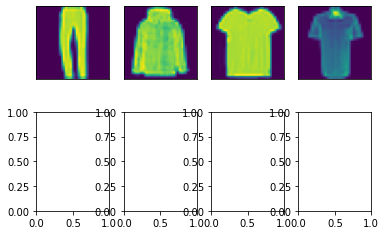

In [8]:
for X, y in train_iter:
    print(X.shape)
    print(y.shape)
    show_images(X.squeeze(axis=1).asnumpy(), 2, 4)
    break

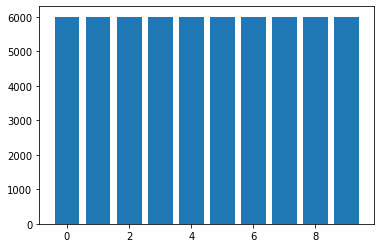

In [9]:
trainX, trainY = train[:]
unique, counts = np.unique(trainY, return_counts=True)
_, ax = plt.subplots()
ax.bar(unique, counts)
plt.show()

In [10]:
ctx = context.gpu()
net = ResNet(10)
net.initialize(init=init.Xavier(), ctx=ctx)

x = nd.random.normal(shape=(1, 1, 112, 112), ctx=ctx)
for i in range(len(net)):
    layer = net[i]
    x = layer(x)
    print(layer.name, x.shape)

conv0 (1, 64, 56, 56)
batchnorm0 (1, 64, 56, 56)
relu0 (1, 64, 56, 56)
pool0 (1, 64, 28, 28)
sequential1 (1, 64, 28, 28)
sequential2 (1, 128, 14, 14)
sequential3 (1, 256, 7, 7)
sequential4 (1, 512, 4, 4)
pool1 (1, 512, 1, 1)
dense0 (1, 10)


In [11]:
print(x)


[[ 0.10520803  0.20311749 -0.13732214 -0.22264129 -0.05391912  0.01597009
  -0.02008746  0.4184385   0.19534719  0.08831199]]
<NDArray 1x10 @gpu(0)>


In [12]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()
print(loss(x, nd.array([1]).as_in_context(ctx)).sum())


[2.1745396]
<NDArray 1 @gpu(0)>


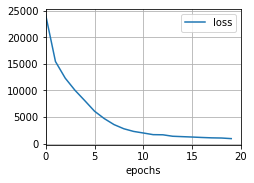

In [13]:
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 3e-4})
epochs = 20
animator = Animator(xlabel='epochs', xlim=[0, epochs], legend=['loss'])

for i in range(epochs):
    epoch_loss = 0
    for X, y in train_iter:
        X, y = X.as_in_context(ctx), y.as_in_context(ctx)
        with autograd.record():
            l = loss(net(X), y)
        l.backward()
        trainer.step(batch_size)
        epoch_loss += l.sum().asscalar()
    animator.add(i, (epoch_loss))